# Restaurant Recommendation Challenge

The objective of this competition is to build a recommendation engine to predict what restaurants customers are most likely to order from given the customer location, restaurant information, and the customer order history.

The error metric for this competition is the F1 score, which ranges from 0 (total failure) to 1 (perfect score). Hence, the closer your score is to 1, the better your model.

[https://www.kaggle.com/mrmorj/restaurant-recommendation-challenge](https://www.kaggle.com/mrmorj/restaurant-recommendation-challenge)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import pickle
from numpy import log, sqrt, log2, ceil, exp
from PreprocessingHelpers import integer_encoding, multiclass_list_encoding, get_sequences, pool_encodings_from_sequences

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
vendors = pd.read_csv('RawData/vendors.csv')
orders = pd.read_csv('RawData/orders.csv')
train_customers = pd.read_csv('RawData/train_customers.csv')
train_locations = pd.read_csv('RawData/train_locations.csv')
test_customers = pd.read_csv('RawData/test_customers.csv')
test_locations = pd.read_csv('RawData/test_locations.csv')

C:\Users\alexp\anaconda3\envs\deep\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (15,16,18,19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Orders
Make sure orders are split properly.

Notes:
- Is **NOT** split into train/test
  - It appears that there are no orders corresponding to the test customers.
  - Perhaps we should split train customers to get test customers with orders.
- 135,233 orders
  - 131,942 made by customers in train_customers.csv
  - Other ~3k orders are ???
- grand_total can be 0
- vendor_discount_amount and promo_discount_percentage are mostly 0
- vendor and driver ratings are mostly either 0 or 5
- deliverydistance can be 0(?) and is at most ~20
- delivery_date can be null but created_at is similar and never null
- promo_code_discount_percentage is unreliable


### Check Some Values

In [3]:
# Train / Test split
train_orders = orders[orders['customer_id'].isin(train_customers['akeed_customer_id'])]
test_orders = orders[orders['customer_id'].isin(test_customers['akeed_customer_id'])]

In [4]:
# Remove duplicate customers and their orders
x = train_customers.groupby('akeed_customer_id').size()
duplicate_train_customers = train_customers[train_customers['akeed_customer_id'].isin(x[x>1].index)]['akeed_customer_id'].unique()
train_customers = train_customers[~train_customers['akeed_customer_id'].isin(duplicate_train_customers)]
train_orders = train_orders[~train_orders['customer_id'].isin(duplicate_train_customers)]

In [5]:
num_train_orders = orders[orders['customer_id'].isin(train_customers['akeed_customer_id'])].shape[0]
num_test_orders = orders[orders['customer_id'].isin(test_customers['akeed_customer_id'])].shape[0]
print(f'Num Orders: {orders.shape[0]}\nNum Train: {num_train_orders}\nNum Test: {num_test_orders}')

Num Orders: 135303
Num Train: 131942
Num Test: 0


In [6]:
train_orders.head(5)

,akeed_order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,vendor_rating,driver_rating,deliverydistance,preparationtime,delivery_time,order_accepted_time,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
0,163238.0,92PEE24,1.0,7.6,2,NaN,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,105,2019-08-01 05:30:16,0,NaN,92PEE24 X 0 X 105
1,163240.0,QS68UD8,1.0,8.7,1,NaN,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,294,2019-08-01 05:31:10,0,Work,QS68UD8 X 0 X 294
2,163241.0,MB7VY5F,2.0,14.4,1,NaN,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:31:33,0,NaN,MB7VY5F X 0 X 83
3,163244.0,KDJ951Y,1.0,7.1,1,NaN,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,2019-08-01 04:03:00,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,90,2019-08-01 05:34:54,0,Home,KDJ951Y X 0 X 90
4,163245.0,BAL0RVT,4.0,27.2,1,NaN,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-07-31 05:30:00,83,2019-08-01 05:35:51,0,Work,BAL0RVT X 0 X 83


In [7]:
pd.concat([train_orders.dtypes.rename('dtype'), train_orders.isnull().sum().rename('num_null')], axis=1)

,dtype,num_null
akeed_order_id,float64,70
customer_id,object,0
item_count,float64,6750
grand_total,float64,0
payment_mode,int64,0
promo_code,object,127743
vendor_discount_amount,float64,0
promo_code_discount_percentage,float64,67772
is_favorite,object,34370
is_rated,object,0


In [8]:
train_orders.describe()

,akeed_order_id,item_count,grand_total,payment_mode,vendor_discount_amount,promo_code_discount_percentage,vendor_rating,driver_rating,deliverydistance,preparationtime,vendor_id,LOCATION_NUMBER
count,131872.000000,125192.000000,131942.000000,131942.000000,131942.000000,64170.000000,44053.000000,131942.000000,131942.000000,77662.000000,131942.000000,131942.000000
mean,265111.183443,2.402566,15.368607,1.343613,0.001065,0.026960,1.953669,0.672690,4.106674,43.213412,238.886352,0.863736
std,85104.501029,1.640521,12.540799,0.761522,0.047824,0.818156,2.312380,1.664523,4.366332,7.112159,226.130161,1.227260
min,11044.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000,4.000000,0.000000
25%,190721.250000,1.000000,8.200000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,40.000000,84.000000,0.000000
50%,267031.500000,2.000000,11.700000,1.000000,0.000000,0.000000,0.000000,0.000000,2.900000,45.000000,154.000000,0.000000
75%,336230.250000,3.000000,18.500000,1.000000,0.000000,0.000000,5.000000,0.000000,7.940000,45.000000,299.000000,1.000000
max,415515.000000,68.000000,783.800000,5.000000,10.650000,25.000000,5.000000,5.000000,19.810000,90.000000,907.000000,19.000000


<AxesSubplot:>

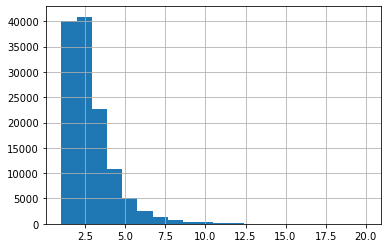

In [9]:
train_orders[train_orders['item_count'] < 20.5]['item_count'].hist(bins=20)

<AxesSubplot:>

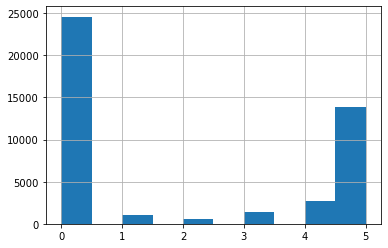

In [10]:
train_orders['vendor_rating'].hist()

<AxesSubplot:>

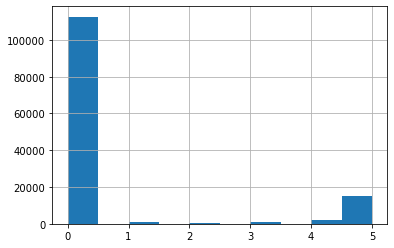

In [11]:
train_orders['driver_rating'].hist()

In [12]:
train_orders['is_favorite'].value_counts()

No     95955
Yes     1617
Name: is_favorite, dtype: int64

In [13]:
train_orders['is_rated'].value_counts()

No     112414
Yes     19528
Name: is_rated, dtype: int64

<AxesSubplot:>

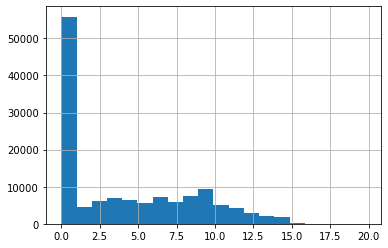

In [14]:
train_orders['deliverydistance'].hist(bins=20)

In [15]:
train_orders['delivery_date'].isnull().value_counts()

True     97229
False    34713
Name: delivery_date, dtype: int64

In [16]:
train_orders['created_at'].isnull().value_counts()

False    131942
Name: created_at, dtype: int64

## Customers

Notes:
- 34,467 customers
  - 26,741 have made at least 1 order
- Most customers have only 1 location
- Outliers in num_locations, dob
- Constant columns: language

### Check Some Values

In [17]:
train_customers.shape[0]

34467

In [18]:
train_customers.head(5)

,akeed_customer_id,gender,dob,status,verified,language,created_at,updated_at
0,TCHWPBT,Male,NaN,1,1,EN,2018-02-07 19:16:23,2018-02-07 19:16:23
1,ZGFSYCZ,Male,NaN,1,1,EN,2018-02-09 12:04:42,2018-02-09 12:04:41
2,S2ALZFL,Male,NaN,0,1,EN,2018-03-14 18:31:43,2018-03-14 18:31:42
3,952DBJQ,Male,NaN,1,1,EN,2018-03-15 19:47:07,2018-03-15 19:47:07
4,1IX6FXS,Male,NaN,1,1,EN,2018-03-15 19:57:01,2018-03-15 19:57:01


In [19]:
pd.concat([train_customers.dtypes.rename('dtype'), train_customers.isnull().sum().rename('num_null')], axis=1)

,dtype,num_null
akeed_customer_id,object,0
gender,object,12154
dob,float64,31428
status,int64,0
verified,int64,0
language,object,13369
created_at,object,0
updated_at,object,0


In [20]:
# Add num_locations as new column in customer table

locations_customer_grp = train_locations.groupby(by=['customer_id'])
locations_per_customer = locations_customer_grp['location_number'].count().rename('num_locations')
train_customers = train_customers.merge(locations_per_customer, how='left', left_on='akeed_customer_id', right_index=True)

In [21]:
# Add num_orders as new column in customer table

orders_per_customer = train_orders.groupby('customer_id')['akeed_order_id'].count().rename('num_orders')
train_customers = train_customers.merge(orders_per_customer, how='left', left_on='akeed_customer_id', right_index=True)

In [22]:
train_customers[train_customers['num_orders'] < 1].shape[0]

1

In [23]:
train_customers['num_orders'].value_counts(dropna=False).sort_index()

0.0         1
1.0      9661
2.0      4596
3.0      2564
4.0      1876
5.0      1360
6.0      1071
7.0       837
8.0       662
9.0       547
10.0      446
11.0      385
12.0      309
13.0      283
14.0      251
15.0      202
16.0      177
17.0      131
18.0      136
19.0      132
20.0      125
21.0       82
22.0       77
23.0       69
24.0       60
25.0       65
26.0       63
27.0       48
28.0       30
29.0       28
30.0       39
31.0       29
32.0       32
33.0       31
34.0       24
35.0       23
36.0       26
37.0       22
38.0       15
39.0       14
40.0       13
41.0       15
42.0       11
43.0       15
44.0        6
45.0       14
46.0        9
47.0        9
48.0       11
49.0        5
50.0       12
51.0        8
52.0        8
53.0        3
54.0        2
55.0        4
56.0        3
57.0        3
58.0        2
59.0        1
60.0        2
61.0        4
62.0        1
63.0        6
64.0        2
65.0        1
66.0        1
67.0        2
68.0        3
69.0        1
70.0        1
71.0  

In [24]:
train_customers['num_orders'].isna().sum()

7725

In [25]:
# Remove customers with no orders
train_customers = train_customers[train_customers['num_orders'] > 0]

In [26]:
train_customers.shape[0]

26741

In [27]:
train_customers['gender'].value_counts()

Male          15145
male           1945
Female         1399
Female            9
Male              8
Female            2
Female            2
Female            1
                  1
Name: gender, dtype: int64

In [28]:
# Clean gender column and remove outliers

train_customers['gender'] = train_customers['gender'].str.strip()
train_customers['gender'] = train_customers['gender'].str.lower()
gender_filter = (train_customers['gender'] == 'male') | (train_customers['gender'] == 'female')
train_customers = train_customers[gender_filter]
train_customers['gender'].value_counts()

male      17098
female     1413
Name: gender, dtype: int64

In [29]:
train_customers['language'].value_counts()

EN    14331
Name: language, dtype: int64

In [30]:
ser = train_customers['created_at'] == train_customers['updated_at']
ser.value_counts()

False    12844
True      5667
dtype: int64

In [31]:
# Train/Test split

test_customers = train_customers.iloc[int(test_customers.shape[0] // 10 * 8):]
train_customers = train_customers.iloc[:int(test_customers.shape[0] // 10 * 8)]

test_orders = train_orders[train_orders['customer_id'].isin(test_customers['akeed_customer_id'])]
train_orders = train_orders[train_orders['customer_id'].isin(train_customers['akeed_customer_id'])]

## Vendors

We should prioritize cleaning this table because it will likely be the most useful data for our model. 

Notes:
- 100 resturaunts
- Outliers present in `latitude`, `longitude`, `preparation_time`, `discount_percentage`
- Constant columns: `commission`, `open_close_flags`, `country_id`, `city_id`, `display_orders`, `one_click_vendor`, `is_akeed_delivering`, `language`
- Nearly constant: `discount_percentage`
- Columns (`status`, `verified`), (`vendor_category_en`, `vendor_category_id`) are almost equal 
- Median and Max `serving_distance` is 15
- `rank` is either 1 or 11...?
- `vendor_rating` has small variance
- `vendor_tag` and `vendor_tag_name` are the same: lists of food types
- Columns recording open/close times are confusing... What is the difference between 1 and 2 and `opening_time`?
- `delivery_charge` is actually categorical

### Checking Some Values

In [32]:
vendors.head(5)

,id,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,OpeningTime2,prepration_time,commission,is_akeed_delivering,discount_percentage,status,verified,rank,language,vendor_rating,sunday_from_time1,sunday_to_time1,sunday_from_time2,sunday_to_time2,monday_from_time1,monday_to_time1,monday_from_time2,monday_to_time2,tuesday_from_time1,tuesday_to_time1,tuesday_from_time2,tuesday_to_time2,wednesday_from_time1,wednesday_to_time1,wednesday_from_time2,wednesday_to_time2,thursday_from_time1,thursday_to_time1,thursday_from_time2,thursday_to_time2,friday_from_time1,friday_to_time1,friday_from_time2,friday_to_time2,saturday_from_time1,saturday_to_time1,saturday_from_time2,saturday_to_time2,primary_tags,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
0,4,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,-,15,0.0,Yes,0.0,1.0,1,11,EN,4.4,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,10:00:00,23:59:00,00:00:00,00:30:00,10:00:00,23:59:00,"{""primary_tags"":""4""}",1.0,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1
1,13,118608.0,-0.471654,0.744470,Restaurants,2.0,0.7,5.0,1.0,08:30AM-10:30PM,-,14,0.0,Yes,0.0,1.0,1,11,EN,4.7,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,19:30:00,00:00:00,01:30:00,08:00:00,19:30:00,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,23:59:00,"{""primary_tags"":""7""}",1.0,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1
2,20,118616.0,-0.407527,0.643681,Restaurants,2.0,0.0,8.0,1.0,08:00AM-10:45PM,-,19,0.0,Yes,0.0,1.0,1,1,EN,4.5,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,"{""primary_tags"":""71""}",1.0,"4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1
3,23,118619.0,-0.585385,0.753811,Restaurants,2.0,0.0,5.0,1.0,10:59AM-10:30PM,-,16,0.0,Yes,0.0,1.0,1,11,EN,4.5,09:00:00,23:30:00,NaN,NaN,09:00:00,23:30:00,NaN,NaN,09:00:00,23:30:00,NaN,NaN,09:00:00,23:30:00,NaN,NaN,09:00:00,23:45:00,NaN,NaN,09:00:00,23:45:00,NaN,NaN,09:00:00,23:45:00,NaN,NaN,"{""primary_tags"":""46""}",1.0,"5,8,30,24","Burgers,Desserts,Fries,Salads",Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1
4,28,118624.0,0.480602,0.552850,Restaurants,2.0,0.7,15.0,1.0,11:00AM-11:45PM,-,10,0.0,Yes,0.0,1.0,1,11,EN,4.4,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,01:30:00,17:45:00,23:59:00,00:01:00,01:30:00,17:45:00,23:59:00,"{""primary_tags"":""32""}",1.0,5,Burgers,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1


In [33]:
# Reindex vendor id
# Set id column to index
vendors.sort_values(by='id')
vendors, v_id_maps, v_inv_maps = integer_encoding(df=vendors, cols=['id'], min_int=1, drop_old=True, monotone_mapping=True)
v_id_map, v_inv_map = v_id_maps['id'], v_inv_maps['id']
vendors.set_index('id', inplace=True)
vendors.head()

,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,OpeningTime2,prepration_time,commission,is_akeed_delivering,discount_percentage,status,verified,rank,language,vendor_rating,sunday_from_time1,sunday_to_time1,sunday_from_time2,sunday_to_time2,monday_from_time1,monday_to_time1,monday_from_time2,monday_to_time2,tuesday_from_time1,tuesday_to_time1,tuesday_from_time2,tuesday_to_time2,wednesday_from_time1,wednesday_to_time1,wednesday_from_time2,wednesday_to_time2,thursday_from_time1,thursday_to_time1,thursday_from_time2,thursday_to_time2,friday_from_time1,friday_to_time1,friday_from_time2,friday_to_time2,saturday_from_time1,saturday_to_time1,saturday_from_time2,saturday_to_time2,primary_tags,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,118597.0,-0.588596,0.754434,Restaurants,2.0,0.0,6.0,1.0,11:00AM-11:30PM,-,15,0.0,Yes,0.0,1.0,1,11,EN,4.4,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,08:00:00,23:59:00,00:00:00,00:30:00,10:00:00,23:59:00,00:00:00,00:30:00,10:00:00,23:59:00,"{""primary_tags"":""4""}",1.0,"2,4,5,8,91,22,12,24,16,23","Arabic,Breakfast,Burgers,Desserts,Free Deliver...",Y,1.0,1.0,2018-01-30 14:42:04,2020-04-07 15:12:43,3,1
2,118608.0,-0.471654,0.744470,Restaurants,2.0,0.7,5.0,1.0,08:30AM-10:30PM,-,14,0.0,Yes,0.0,1.0,1,11,EN,4.7,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,19:30:00,00:00:00,01:30:00,08:00:00,19:30:00,00:00:00,01:30:00,08:00:00,23:59:00,00:00:00,01:30:00,08:00:00,23:59:00,"{""primary_tags"":""7""}",1.0,"4,41,51,34,27,15,24,16,28","Breakfast,Cakes,Crepes,Italian,Pasta,Pizzas,Sa...",Y,1.0,1.0,2018-05-03 12:32:06,2020-04-05 20:46:03,3,1
3,118616.0,-0.407527,0.643681,Restaurants,2.0,0.0,8.0,1.0,08:00AM-10:45PM,-,19,0.0,Yes,0.0,1.0,1,1,EN,4.5,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,08:00:00,22:45:00,NaN,NaN,"{""primary_tags"":""71""}",1.0,"4,8,91,10","Breakfast,Desserts,Free Delivery,Indian",Y,1.0,1.0,2018-05-04 22:28:22,2020-04-07 16:35:55,3,1
4,118619.0,-0.585385,0.753811,Restaurants,2.0,0.0,5.0,1.0,10:59AM-10:30PM,-,16,0.0,Yes,0.0,1.0,1,11,EN,4.5,09:00:00,23:30:00,NaN,NaN,09:00:00,23:30:00,NaN,NaN,09:00:00,23:30:00,NaN,NaN,09:00:00,23:30:00,NaN,NaN,09:00:00,23:45:00,NaN,NaN,09:00:00,23:45:00,NaN,NaN,09:00:00,23:45:00,NaN,NaN,"{""primary_tags"":""46""}",1.0,"5,8,30,24","Burgers,Desserts,Fries,Salads",Y,1.0,1.0,2018-05-06 19:20:48,2020-04-02 00:56:17,3,1
5,118624.0,0.480602,0.552850,Restaurants,2.0,0.7,15.0,1.0,11:00AM-11:45PM,-,10,0.0,Yes,0.0,1.0,1,11,EN,4.4,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,01:30:00,17:45:00,23:59:00,00:01:00,01:30:00,17:45:00,23:59:00,"{""primary_tags"":""32""}",1.0,5,Burgers,Y,1.0,1.0,2018-05-17 22:12:38,2020-04-05 15:57:41,3,1


In [34]:
pd.concat([vendors.dtypes.rename('dtype'), vendors.isnull().sum().rename('num_null')], axis=1)

,dtype,num_null
authentication_id,float64,0
latitude,float64,0
longitude,float64,0
vendor_category_en,object,0
vendor_category_id,float64,0
delivery_charge,float64,0
serving_distance,float64,0
is_open,float64,0
OpeningTime,object,9
OpeningTime2,object,9


In [35]:
vendors.describe()

,authentication_id,latitude,longitude,vendor_category_id,delivery_charge,serving_distance,is_open,prepration_time,commission,discount_percentage,status,verified,rank,vendor_rating,open_close_flags,country_id,city_id,device_type,display_orders
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.00000,85.0,100.000000,100.00000,100.000000,100.00000,100.000000,100.0,100.0,100.0,100.00,100.0
mean,120050.760000,1.875505,0.803682,2.110000,0.413000,11.750000,0.85000,14.03000,0.0,1.100000,0.85000,0.880000,9.90000,4.350000,1.0,1.0,1.0,2.98,1.0
std,3509.069064,20.600857,4.397859,0.314466,0.346018,4.108073,0.35887,4.31688,0.0,6.299751,0.35887,0.326599,3.14466,0.248836,0.0,0.0,0.0,0.20,0.0
min,118597.000000,-1.787413,-1.449556,2.000000,0.000000,2.000000,0.00000,5.00000,0.0,0.000000,0.00000,0.000000,1.00000,3.200000,1.0,1.0,1.0,1.00,1.0
25%,118702.750000,-0.809124,0.081618,2.000000,0.000000,8.000000,1.00000,10.00000,0.0,0.000000,1.00000,1.000000,11.00000,4.200000,1.0,1.0,1.0,3.00,1.0
50%,118801.000000,-0.493421,0.527123,2.000000,0.700000,15.000000,1.00000,15.00000,0.0,0.000000,1.00000,1.000000,11.00000,4.400000,1.0,1.0,1.0,3.00,1.0
75%,118990.250000,0.015915,0.644764,2.000000,0.700000,15.000000,1.00000,15.00000,0.0,0.000000,1.00000,1.000000,11.00000,4.500000,1.0,1.0,1.0,3.00,1.0
max,132953.000000,205.242327,44.210807,3.000000,0.700000,15.000000,1.00000,45.00000,0.0,50.000000,1.00000,1.000000,11.00000,4.800000,1.0,1.0,1.0,3.00,1.0


In [36]:
vendors['is_akeed_delivering'].value_counts()

Yes    100
Name: is_akeed_delivering, dtype: int64

In [37]:
vendors['language'].value_counts()

EN    85
Name: language, dtype: int64

In [38]:
vendors['one_click_vendor'].value_counts()

Y    100
Name: one_click_vendor, dtype: int64

<AxesSubplot:>

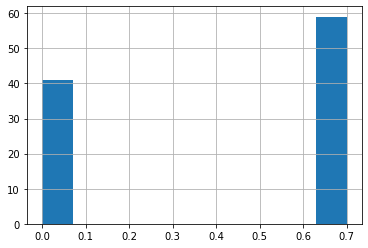

In [39]:
vendors['delivery_charge'].hist()

<AxesSubplot:>

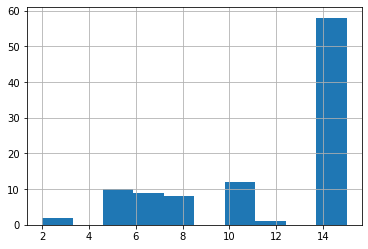

In [40]:
vendors['serving_distance'].hist()

<AxesSubplot:>

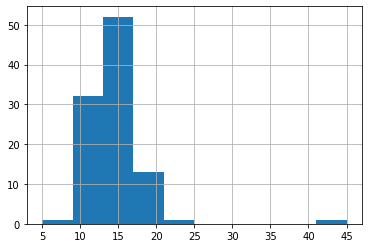

In [41]:
vendors['prepration_time'].hist()

<AxesSubplot:>

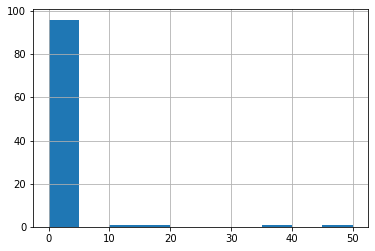

In [42]:
vendors['discount_percentage'].hist()

In [43]:
vendors['rank'].value_counts()

11    89
1     11
Name: rank, dtype: int64

<AxesSubplot:>

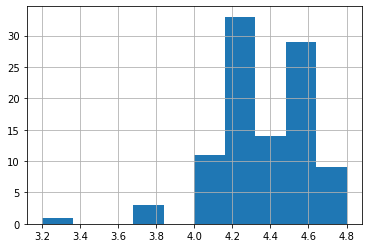

In [44]:
vendors['vendor_rating'].hist()

In [45]:
vendors['status'].value_counts()

1.0    85
0.0    15
Name: status, dtype: int64

In [46]:
vendors['verified'].value_counts()

1    88
0    12
Name: verified, dtype: int64

In [47]:
vendors[vendors['verified'] == 0]['status'].value_counts()

0.0    12
Name: status, dtype: int64

In [48]:
vendors['device_type'].value_counts()

3    99
1     1
Name: device_type, dtype: int64

In [49]:
vendors[vendors.device_type == 1]   # Is a location outlier...?

,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,OpeningTime2,prepration_time,commission,is_akeed_delivering,discount_percentage,status,verified,rank,language,vendor_rating,sunday_from_time1,sunday_to_time1,sunday_from_time2,sunday_to_time2,monday_from_time1,monday_to_time1,monday_from_time2,monday_to_time2,tuesday_from_time1,tuesday_to_time1,tuesday_from_time2,tuesday_to_time2,wednesday_from_time1,wednesday_to_time1,wednesday_from_time2,wednesday_to_time2,thursday_from_time1,thursday_to_time1,thursday_from_time2,thursday_to_time2,friday_from_time1,friday_to_time1,friday_from_time2,friday_to_time2,saturday_from_time1,saturday_to_time1,saturday_from_time2,saturday_to_time2,primary_tags,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
56,118830.0,205.242327,44.210807,Sweets & Bakes,3.0,0.7,10.0,1.0,9am-10pm,10pm-11pm,15,0.0,Yes,0.0,1.0,1,11,EN,4.3,NaN,NaN,NaN,NaN,09:00:00,21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,10:00:00,16:01:00,17:00:00,23:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Y,1.0,1.0,2019-04-24 20:04:18,2020-03-20 09:45:15,1,1


### Cleaning Vendor Categories

In [50]:
vendors['vendor_category_en'].value_counts()

Restaurants       88
Sweets & Bakes    12
Name: vendor_category_en, dtype: int64

In [51]:
vendors['vendor_category_id'].value_counts()

2.0    89
3.0    11
Name: vendor_category_id, dtype: int64

In [52]:
vendors[(vendors['vendor_category_en'] == "Sweets & Bakes") & (vendors['vendor_category_id'] == 3.0)].shape[0]

11

In [53]:
vendors[(vendors['vendor_category_en'] == "Sweets & Bakes") & (vendors['vendor_category_id'] == 2.0)]

,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,OpeningTime2,prepration_time,commission,is_akeed_delivering,discount_percentage,status,verified,rank,language,vendor_rating,sunday_from_time1,sunday_to_time1,sunday_from_time2,sunday_to_time2,monday_from_time1,monday_to_time1,monday_from_time2,monday_to_time2,tuesday_from_time1,tuesday_to_time1,tuesday_from_time2,tuesday_to_time2,wednesday_from_time1,wednesday_to_time1,wednesday_from_time2,wednesday_to_time2,thursday_from_time1,thursday_to_time1,thursday_from_time2,thursday_to_time2,friday_from_time1,friday_to_time1,friday_from_time2,friday_to_time2,saturday_from_time1,saturday_to_time1,saturday_from_time2,saturday_to_time2,primary_tags,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
29,118712.0,0.578865,0.52827,Sweets & Bakes,2.0,0.0,15.0,1.0,09:59AM-11:45PM,-,13,0.0,Yes,0.0,1.0,1,11,EN,4.8,10:00:00,23:45:00,NaN,NaN,10:00:00,23:45:00,NaN,NaN,10:00:00,23:45:00,NaN,NaN,10:00:00,23:45:00,NaN,NaN,10:00:00,23:45:00,NaN,NaN,15:00:00,23:45:00,NaN,NaN,10:00:00,23:45:00,NaN,NaN,"{""primary_tags"":""138""}",1.0,"8,91,9,56","Desserts,Free Delivery,Healthy Food,Sweets",Y,1.0,1.0,2018-10-28 13:34:59,2020-04-06 13:44:19,3,1


In [54]:
# Fix incorrect vendor_category_id
vendors.loc[28, 'vendor_category_id'] = 3.0

### Cleaning Vendor Tags

In [55]:
vendors['primary_tags'].value_counts()

{"primary_tags":"134"}     10
{"primary_tags":"2396"}     8
{"primary_tags":"8"}        5
{"primary_tags":"701"}      3
{"primary_tags":"46"}       3
{"primary_tags":"32"}       3
{"primary_tags":"2072"}     3
{"primary_tags":"24"}       3
{"primary_tags":"1088"}     3
{"primary_tags":"28"}       2
{"primary_tags":"21"}       2
{"primary_tags":"90"}       2
{"primary_tags":"1348"}     1
{"primary_tags":"695"}      1
{"primary_tags":"47"}       1
{"primary_tags":"15"}       1
{"primary_tags":"297"}      1
{"primary_tags":"4"}        1
{"primary_tags":"129"}      1
{"primary_tags":"849"}      1
{"primary_tags":"271"}      1
{"primary_tags":"7"}        1
{"primary_tags":"336"}      1
{"primary_tags":"1065"}     1
{"primary_tags":"71"}       1
{"primary_tags":"534"}      1
{"primary_tags":"323"}      1
{"primary_tags":"35"}       1
{"primary_tags":"180"}      1
{"primary_tags":"346"}      1
{"primary_tags":"52"}       1
{"primary_tags":"462"}      1
{"primary_tags":"138"}      1
{"primary_

In [56]:
# Fill na with -1
# Strip unnecessary characters
vendors['primary_tags'] = vendors['primary_tags'].fillna("{\"primary_tags\":\"-1\"}").apply(lambda x: int(str(x).split("\"")[3]))
vendors['primary_tags'].value_counts().head(5)

-1       23
 134     10
 2396     8
 8        5
 24       3
Name: primary_tags, dtype: int64

In [57]:
vendors[vendors['primary_tags'] == 134]

,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,OpeningTime2,prepration_time,commission,is_akeed_delivering,discount_percentage,status,verified,rank,language,vendor_rating,sunday_from_time1,sunday_to_time1,sunday_from_time2,sunday_to_time2,monday_from_time1,monday_to_time1,monday_from_time2,monday_to_time2,tuesday_from_time1,tuesday_to_time1,tuesday_from_time2,tuesday_to_time2,wednesday_from_time1,wednesday_to_time1,wednesday_from_time2,wednesday_to_time2,thursday_from_time1,thursday_to_time1,thursday_from_time2,thursday_to_time2,friday_from_time1,friday_to_time1,friday_from_time2,friday_to_time2,saturday_from_time1,saturday_to_time1,saturday_from_time2,saturday_to_time2,primary_tags,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17,118679.0,-0.417192,0.645850,Restaurants,2.0,0.7,8.0,1.0,08:00AM-11:59PM,-,11,0.0,Yes,0.0,1.0,1,11,EN,4.4,00:01:00,01:30:00,10:00:00,23:59:00,00:01:00,01:30:00,10:00:00,23:59:00,00:01:00,01:30:00,10:00:00,23:59:00,00:01:00,01:30:00,10:00:00,23:59:00,00:01:00,01:30:00,10:00:00,23:59:00,00:01:00,01:30:00,10:00:00,23:59:00,00:01:00,01:30:00,10:00:00,23:59:00,134,1.0,"4,8,12,50,15,24,16","Breakfast,Desserts,Lebanese,Manakeesh,Pizzas,S...",Y,1.0,1.0,2018-09-03 19:30:50,2020-04-07 16:38:17,3,1
24,118701.0,-0.032442,0.655636,Restaurants,2.0,0.0,2.0,1.0,10:59AM-11:30PM,-,10,0.0,Yes,0.0,1.0,1,11,EN,4.5,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,13:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,134,1.0,"1,5,91,29,27","American,Burgers,Free Delivery,Hot Dogs,Pasta",Y,1.0,1.0,2018-10-18 21:01:20,2020-04-03 22:28:50,3,1
25,118702.0,-0.967769,0.080839,Restaurants,2.0,0.0,15.0,1.0,10:59AM-11:30PM,-,12,0.0,Yes,0.0,1.0,1,11,EN,4.5,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,00:01:00,00:30:00,13:00:00,23:59:00,00:01:00,00:30:00,11:00:00,23:59:00,134,1.0,"1,5,91,29,27","American,Burgers,Free Delivery,Hot Dogs,Pasta",Y,1.0,1.0,2018-10-19 12:38:55,2020-04-07 23:41:41,3,1
32,118745.0,-0.482865,0.075989,Restaurants,2.0,0.7,15.0,1.0,08:00AM-11:45PM,-,16,0.0,Yes,15.0,1.0,1,11,EN,4.1,00:00:00,00:30:00,12:30:00,23:59:00,00:01:00,00:30:00,12:30:00,23:59:00,00:01:00,00:30:00,12:30:00,23:59:00,00:01:00,00:30:00,12:30:00,23:59:00,00:01:00,00:30:00,12:30:00,23:59:00,00:00:00,00:30:00,12:30:00,23:59:00,00:01:00,00:30:00,12:30:00,23:59:00,134,1.0,"4,5,22,89,16,23","Breakfast,Burgers,Grills,Pizza,Sandwiches,Shaw...",Y,1.0,1.0,2018-12-30 20:20:31,2020-04-07 00:36:36,3,1
60,118860.0,0.025821,0.551594,Restaurants,2.0,0.0,15.0,1.0,05:00PM-11:59PM,-,15,0.0,Yes,0.0,1.0,1,11,EN,4.3,12:00:00,22:00:00,NaN,NaN,12:00:00,22:00:00,NaN,NaN,12:00:00,22:00:00,NaN,NaN,12:00:00,22:00:00,NaN,NaN,12:00:00,22:00:00,NaN,NaN,12:00:00,22:00:00,NaN,NaN,12:00:00,22:00:00,NaN,NaN,134,1.0,"1,5,48,27,16,36,28,35","American,Burgers,Kids meal,Pasta,Sandwiches,Sm...",Y,1.0,1.0,2019-05-21 16:05:12,2020-04-07 21:56:19,3,1
62,118872.0,-0.334340,0.726333,Restaurants,2.0,0.7,5.0,1.0,05:00PM-11:45PM,-,11,0.0,Yes,0.0,1.0,1,11,EN,4.5,12:00:00,22:00:00,NaN,NaN,12:00:00,22:00:00,NaN,NaN,12:00:00,22:00:00,NaN,NaN,12:00:00,22:00:00,NaN,NaN,12:00:00,22:00:00,NaN,NaN,12:00:00,22:00:00,NaN,NaN,12:00:00,22:00:00,NaN,NaN,134,1.0,"1,5,48,27,16,36,28,35","American,Burgers,Kids meal,Pasta,Sandwiches,Sm...",Y,1.0,1.0,2019-05-28 13:36:00,2020-04-03 22:18:52,3,1
83,119180.0,2.015615,0.749220,Restaurants,2.0,0.0,15.0,1.0,04:59PM-11:45PM,-,10,0.0,Yes,0.0,1.0,1,11,EN,4.6,17:00:00,23:45:00,NaN,NaN,17:00:00,23:45:00,NaN,NaN,17:00:00,23:45:00,NaN,NaN,17:00:00,23:45:00,NaN,NaN,17:00:00

In [58]:
# Fill na with -1
# Turn vendor_tag into list-valued
vendors['vendor_tag'] = vendors['vendor_tag'].fillna(str(-1)).apply(lambda x: x.split(",")).apply(lambda x: [int(i) for i in x])
vendors['vendor_tag'].head(10)

id
1     [2, 4, 5, 8, 91, 22, 12, 24, 16, 23]
2      [4, 41, 51, 34, 27, 15, 24, 16, 28]
3                           [4, 8, 91, 10]
4                           [5, 8, 30, 24]
5                                      [5]
6                                  [8, 42]
7                           [1, 5, 30, 16]
8                           [1, 5, 30, 16]
9               [4, 8, 22, 32, 24, 16, 28]
10                       [4, 5, 8, 10, 24]
Name: vendor_tag, dtype: object

In [59]:
# Get unique vendor tags
# Map values to range(len(vendor_tags))
vendor_tags = [int(i) for i in vendors['vendor_tag'].explode().unique()]
vendor_tags.sort()
vendor_map = dict()
for i, tag in enumerate(vendor_tags):
    vendor_map[tag] = i
vendors['vendor_tag'] = vendors['vendor_tag'].apply(lambda tags: [vendor_map[tag] for tag in tags])
vendors['vendor_tag'].head(10)

id
1     [2, 4, 5, 8, 67, 19, 12, 21, 15, 20]
2      [4, 35, 45, 31, 24, 14, 21, 15, 25]
3                           [4, 8, 67, 10]
4                           [5, 8, 27, 21]
5                                      [5]
6                                  [8, 36]
7                           [1, 5, 27, 15]
8                           [1, 5, 27, 15]
9               [4, 8, 19, 29, 21, 15, 25]
10                       [4, 5, 8, 10, 21]
Name: vendor_tag, dtype: object

In [60]:
# Combine status and verified features
vendors['status_and_verified'] = vendors['status'] * vendors['verified']
vendors['status_and_verified'].value_counts()

1.0    85
0.0    15
Name: status_and_verified, dtype: int64

### Creating Some Order-Based Features

In [61]:
# Add num_orders, amt_sales, and avg_sale as new columns in vendor table

train_orders_vendor_grp = train_orders.groupby(by=['vendor_id'])
train_orders_per_vendor = train_orders_vendor_grp['akeed_order_id'].count().rename('num_orders')
train_orders_per_vendor.index = train_orders_per_vendor.index.map(v_id_map)
train_grand_total_per_vendor = train_orders_vendor_grp['grand_total'].sum().rename('amt_sales')
train_grand_total_per_vendor.index = train_grand_total_per_vendor.index.map(v_id_map)

test_orders_vendor_grp = test_orders.groupby(by=['vendor_id'])
test_orders_per_vendor = test_orders_vendor_grp['akeed_order_id'].count().rename('num_orders')
test_orders_per_vendor.index = test_orders_per_vendor.index.map(v_id_map)
test_grand_total_per_vendor = test_orders_vendor_grp['grand_total'].sum().rename('amt_sales')
test_grand_total_per_vendor.index = test_grand_total_per_vendor.index.map(v_id_map)

vendors = vendors.merge(train_orders_per_vendor, how='left', left_on='id', right_index=True)
vendors = vendors.merge(train_grand_total_per_vendor, how='left', left_on='id', right_index=True)
vendors['avg_sale'] = vendors['amt_sales'] / vendors['num_orders']

In [62]:
# Save most popular vendors
popular_vendors = vendors['num_orders'].sort_values(ascending=False)

with open("ProcessedData/popular_vendors.pkl", "wb") as file:
    pickle.dump(popular_vendors, file)

<AxesSubplot:>

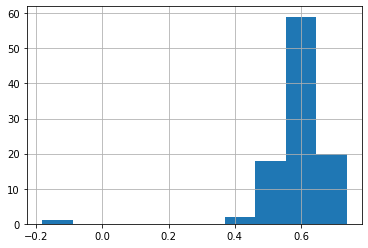

In [63]:
vendors['num_orders_log3'] = vendors['num_orders'].apply(log).apply(log).apply(log)
vendors['num_orders_log3'].hist()

<AxesSubplot:>

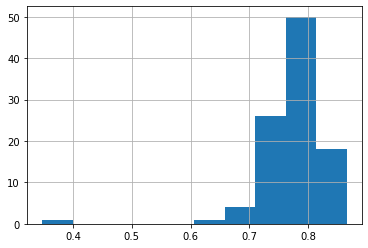

In [64]:
vendors['amt_sales_log3'] = vendors['amt_sales'].apply(log).apply(log).apply(log)
vendors['amt_sales_log3'].hist()

<AxesSubplot:>

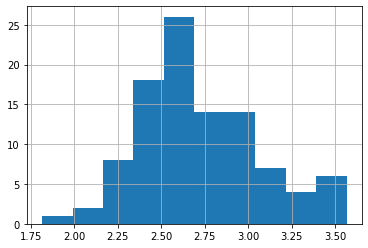

In [65]:
vendors['avg_sale_log'] = vendors['avg_sale'].apply(log)
vendors['avg_sale_log'].hist()

### Transforming Location Outliers

In [66]:
# Examine the location outliers

vendors[vendors['latitude'] > 3]

,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,OpeningTime2,prepration_time,commission,is_akeed_delivering,discount_percentage,status,verified,rank,language,vendor_rating,sunday_from_time1,sunday_to_time1,sunday_from_time2,sunday_to_time2,monday_from_time1,monday_to_time1,monday_from_time2,monday_to_time2,tuesday_from_time1,tuesday_to_time1,tuesday_from_time2,tuesday_to_time2,wednesday_from_time1,wednesday_to_time1,wednesday_from_time2,wednesday_to_time2,thursday_from_time1,thursday_to_time1,thursday_from_time2,thursday_to_time2,friday_from_time1,friday_to_time1,friday_from_time2,friday_to_time2,saturday_from_time1,saturday_to_time1,saturday_from_time2,saturday_to_time2,primary_tags,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders,status_and_verified,num_orders,amt_sales,avg_sale,num_orders_log3,amt_sales_log3,avg_sale_log
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
56,118830.0,205.242327,44.210807,Sweets & Bakes,3.0,0.7,10.0,1.0,9am-10pm,10pm-11pm,15,0.0,Yes,0.0,1.0,1,11,EN,4.3,NaN,NaN,NaN,NaN,09:00:00,21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,10:00:00,16:01:00,17:00:00,23:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.0,[0],NaN,Y,1.0,1.0,2019-04-24 20:04:18,2020-03-20 09:45:15,1,1,1.0,428,4193.0,9.796729,0.588656,0.751984,2.282049
100,132953.0,13.335131,-1.449556,Restaurants,2.0,0.7,12.0,1.0,NaN,NaN,20,NaN,Yes,0.0,1.0,1,11,NaN,4.3,11:00:00,12:30:00,16:30:00,23:15:00,11:00:00,12:30:00,16:30:00,23:15:00,11:00:00,12:30:00,16:30:00,23:15:00,11:00:00,12:30:00,16:30:00,23:15:00,11:00:00,12:30:00,16:30:00,23:15:00,NaN,NaN,16:30:00,23:15:00,11:00:00,12:30:00,16:30:00,23:15:00,24,1.0,"[40, 46, 15]","Fatayers,Mojitos ,Sandwiches",Y,1.0,1.0,2020-01-05 18:56:58,2020-04-06 23:49:52,3,1,1.0,10,61.4,6.140000,-0.181483,0.347288,1.814825


In [67]:
vendors[vendors['longitude'] > 3]

,authentication_id,latitude,longitude,vendor_category_en,vendor_category_id,delivery_charge,serving_distance,is_open,OpeningTime,OpeningTime2,prepration_time,commission,is_akeed_delivering,discount_percentage,status,verified,rank,language,vendor_rating,sunday_from_time1,sunday_to_time1,sunday_from_time2,sunday_to_time2,monday_from_time1,monday_to_time1,monday_from_time2,monday_to_time2,tuesday_from_time1,tuesday_to_time1,tuesday_from_time2,tuesday_to_time2,wednesday_from_time1,wednesday_to_time1,wednesday_from_time2,wednesday_to_time2,thursday_from_time1,thursday_to_time1,thursday_from_time2,thursday_to_time2,friday_from_time1,friday_to_time1,friday_from_time2,friday_to_time2,saturday_from_time1,saturday_to_time1,saturday_from_time2,saturday_to_time2,primary_tags,open_close_flags,vendor_tag,vendor_tag_name,one_click_vendor,country_id,city_id,created_at,updated_at,device_type,display_orders,status_and_verified,num_orders,amt_sales,avg_sale,num_orders_log3,amt_sales_log3,avg_sale_log
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
56,118830.0,205.242327,44.210807,Sweets & Bakes,3.0,0.7,10.0,1.0,9am-10pm,10pm-11pm,15,0.0,Yes,0.0,1.0,1,11,EN,4.3,NaN,NaN,NaN,NaN,09:00:00,21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,10:00:00,16:01:00,17:00:00,23:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.0,[0],NaN,Y,1.0,1.0,2019-04-24 20:04:18,2020-03-20 09:45:15,1,1,1.0,428,4193.0,9.796729,0.588656,0.751984,2.282049


In [68]:
orders_55 = train_orders[train_orders['vendor_id'] == 55]
orders_99 = train_orders[train_orders['vendor_id'] == 99]

orders_55 = orders_55.merge(train_locations, how='left', left_on=['customer_id', 'LOCATION_NUMBER'], right_on=['customer_id', 'location_number'])
orders_99 = orders_99.merge(train_locations, how='left', left_on=['customer_id', 'LOCATION_NUMBER'], right_on=['customer_id', 'location_number'])

In [69]:
lat55 = vendors[vendors.index == 55].latitude.item()
long55 = vendors[vendors.index == 55].longitude.item()
lat99 = vendors[vendors.index == 99].latitude.item()
long99 = vendors[vendors.index == 99].longitude.item()

print(f'55 actual: \tLat = {lat55:.3f}, Long = {long55:.3f}')
print(f'55 estimate: \tLat = {orders_55.latitude.median():.3f}, Long = {orders_55.longitude.median():.3f}')
print(f'99 actual: \tLat = {lat99:.3f}, Long = {long99:.3f}')
print(f'99 estimate: \tLat = {orders_99.latitude.median():.3f}, Long = {orders_99.longitude.median():.3f}')

55 actual: 	Lat = -0.815, Long = 0.091
55 estimate: 	Lat = -0.539, Long = 0.065
99 actual: 	Lat = 0.020, Long = 0.587
99 estimate: 	Lat = nan, Long = nan


In [70]:
orders_55.describe()

,akeed_order_id,item_count,grand_total,payment_mode,vendor_discount_amount,promo_code_discount_percentage,vendor_rating,driver_rating,deliverydistance,preparationtime,vendor_id,LOCATION_NUMBER,location_number,latitude,longitude
count,378.000000,366.000000,378.000000,378.000000,378.0,141.0,170.000000,378.000000,378.000000,230.000000,378.0,378.000000,378.000000,378.000000,378.000000
mean,251749.261905,2.953552,16.823016,1.574074,0.0,0.0,1.235294,0.574074,3.933704,49.956522,55.0,1.473545,1.473545,-0.577379,-19.247248
std,71679.222537,1.725085,12.870808,1.025440,0.0,0.0,2.096190,1.560815,4.455631,6.946321,0.0,1.862826,1.862826,0.520355,33.925674
min,11628.000000,1.000000,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,40.000000,55.0,0.000000,0.000000,-2.032466,-78.667040
25%,213855.500000,2.000000,8.800000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,45.000000,55.0,0.000000,0.000000,-0.995785,-0.136383
50%,253142.000000,3.000000,13.300000,1.000000,0.0,0.0,0.000000,0.000000,2.760000,50.000000,55.0,1.000000,1.000000,-0.539044,0.065312
75%,291643.500000,4.000000,21.200000,2.000000,0.0,0.0,2.500000,0.000000,6.790000,55.000000,55.0,2.000000,2.000000,-0.251474,0.116325
max,415075.000000,12.000000,93.000000,5.000000,0.0,0.0,5.000000,5.000000,15.000000,80.000000,55.0,12.000000,12.000000,0.754218,0.944360


In [71]:
orders_99.describe()

,akeed_order_id,item_count,grand_total,payment_mode,vendor_discount_amount,promo_code_discount_percentage,vendor_rating,driver_rating,deliverydistance,preparationtime,vendor_id,LOCATION_NUMBER,location_number,latitude,longitude
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
train_locations.head(5)

,customer_id,location_number,location_type,latitude,longitude
0,02SFNJH,0,NaN,1.682392,-78.789737
1,02SFNJH,1,NaN,1.679137,0.766823
2,02SFNJH,2,NaN,-0.498648,0.661241
3,RU43CXC,0,Home,0.100853,0.438165
4,BDFBPRD,0,NaN,2.523125,0.733464


In [73]:
pd.concat([train_locations.dtypes.rename('dtype'), train_locations.isnull().sum().rename('num_null')], axis=1)

,dtype,num_null
customer_id,object,0
location_number,int64,0
location_type,object,27209
latitude,float64,6
longitude,float64,6


In [74]:
# Aggregate # orders, $ sales, and avg spent by customer location
# (customers can have multiple locations registered to themselves)

orders_location_grp = train_orders.groupby(['customer_id', 'LOCATION_NUMBER'])
orders_per_location = orders_location_grp['akeed_order_id'].count().rename('num_orders')    # multi index: [customer_id, LOCATION_NUMBER]
sales_per_location = orders_location_grp['grand_total'].sum().rename('amt_spent')           # multi index: [customer_id, LOCATION_NUMBER]

train_locations = train_locations.merge(sales_per_location, how='left', left_on=['customer_id', 'location_number'], right_index=True)
train_locations = train_locations.merge(orders_per_location, how='left', left_on=['customer_id', 'location_number'], right_index=True)
train_locations['avg_spend'] = train_locations['amt_spent'] / train_locations['num_orders']


In [75]:
# Filter locations which have not been ordered from

train_locations = train_locations[train_locations['num_orders'] != 0]

In [76]:
train_locations.describe()

,location_number,latitude,longitude,amt_spent,num_orders,avg_spend
count,59502.000000,59496.000000,59496.000000,16649.000000,16649.000000,16649.000000
mean,0.753555,2.361192,-25.115835,59.763115,3.706649,16.816477
std,1.355625,22.734296,36.946180,92.090047,5.071138,12.316289
min,0.000000,-1038.149292,-134.415302,0.000000,1.000000,0.000000
25%,0.000000,-0.502559,-78.522569,14.400000,1.000000,9.457143
50%,0.000000,-0.087855,0.021341,29.400000,2.000000,13.562500
75%,1.000000,0.261738,0.514673,66.300000,4.000000,20.100000
max,29.000000,453.653846,45.354231,2091.400000,125.000000,204.100000


In [77]:
train_locations[train_locations['amt_spent'] == 0].merge(train_orders, left_on=['customer_id', 'location_number'], right_on=['customer_id', 'LOCATION_NUMBER']).head(3)     # Free orders

,customer_id,location_number,location_type,latitude,longitude,amt_spent,num_orders,avg_spend,akeed_order_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,vendor_rating,driver_rating,deliverydistance,preparationtime,delivery_time,order_accepted_time,driver_accepted_time,ready_for_pickup_time,picked_up_time,delivered_time,delivery_date,vendor_id,created_at,LOCATION_NUMBER,LOCATION_TYPE,CID X LOC_NUM X VENDOR
0,CJ9963E,1,Home,-0.116336,-0.046987,0.0,1.0,0.0,235667.0,1.0,0.0,5,Akeed235553,0.0,NaN,No,No,0.0,0.0,0.0,NaN,NaN,2019-10-25 13:37:58,NaN,2019-10-25 13:43:53,2019-10-25 17:50:36,2019-10-25 18:01:27,NaN,86,2019-10-25 17:36:25,1,Home,CJ9963E X 1 X 86
1,TI95U8F,0,Home,0.057783,-78.597738,0.0,1.0,0.0,166435.0,2.0,0.0,1,burgerhood,0.0,NaN,NaN,No,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-05 05:30:00,294,2019-08-06 04:35:13,0,Home,TI95U8F X 0 X 294
2,TC8OO98,0,NaN,-0.287959,-78.556878,0.0,1.0,0.0,191906.0,4.0,0.0,5,AK10380,0.0,NaN,NaN,Yes,5.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-13 05:30:00,391,2019-09-13 23:16:03,0,NaN,TC8OO98 X 0 X 391


**Note from VariableDefinitions.txt:** 

"Not true latitude and longitude - locations have been masked, but nearby locations remain nearby in the new reference frame and can thus be used for clustering. However, not all locations are useful due to GPS errors and missing data - you may want to treat outliers separately."

This will make our life difficult because we have no way of knowing how the location data has been transformed, thus it's not really clear how we should define "outlier".

Almost all vendors are clustered very close to each other, but we will soon see that about 1/3rd of customer locations are "far" from this cluster.


In [78]:
# Map out customer locations and vendor locations

plt.figure(figsize=(15, 15))
plt.scatter(x=train_locations.longitude, y=train_locations.latitude, label='Customers', marker='s', alpha=0.2)
plt.scatter(x=vendors.longitude, y=vendors.latitude, label='Vendors', marker='*', alpha=0.5, s=vendors['num_orders']/5, c=vendors['avg_sale'], cmap='plasma')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='lower right')
plt.colorbar(label='$ Avg Sale')
plt.title('Customer + Vendor Locations')
plt.show()

# Stars:
#   Size: Unpopular <----------> Popular
#   Heat:     Cheap <----------> Expensive

In [ ]:
# Outliers in location are probably a mistake (GPS error?)
# Zoom in on area close with most activity
#     Marker Size = # Orders
#           Color = $ Grand Total

lo = -5
hi = 5

filt1 = (lo < train_locations['longitude']) & (train_locations['longitude'] < hi)
filt2 = (lo < vendors['longitude']) & (vendors['longitude'] < hi)
train_locations_cut = train_locations[filt1]
vendors_cut = vendors[filt2]

plt.figure(figsize=(15, 15))
plt.scatter(x=train_locations_cut.longitude, y=train_locations_cut.latitude, label='Customers', marker='s', alpha=0.1)
plt.scatter(x=vendors_cut.longitude, y=vendors_cut.latitude, label='Vendors', marker='*', alpha=0.5, s=vendors_cut['num_orders']/7, c=vendors_cut['avg_sale'], cmap='plasma')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='lower right')
plt.colorbar(label='$ Avg Sale')
plt.title('Customer + Vendor Locations (Zoomed)')
plt.show()

# Stars:
#   Size: Unpopular <----------> Popular
#   Heat:     Cheap <----------> Expensive


In [ ]:
# Define outliers for customer locations
# There are a lot of customers that are outside the "vendor bubble"
#   vendor bubble == customers that aren't outliers

lat_lo, lat_hi = -25, 25
long_lo, long_hi = -5, 5
c_outliers = (train_locations['latitude'] < lat_lo) | (train_locations['latitude'] > lat_hi) | (train_locations['longitude'] < long_lo) | (train_locations['longitude'] > long_hi)
v_outliers = (vendors['latitude'] < lat_lo) | (vendors['latitude'] > lat_hi) | (vendors['longitude'] < long_lo) | (vendors['longitude'] > long_hi)


train_locations[c_outliers].describe()

In [ ]:
# Want to transform outliers so that they are closer to vendors, but also stay in their clusters
#   Project outliers onto ellipse around bubble



lat_radius = lat_hi
long_radius = long_hi

# Project customer outliers
for i in tqdm(train_locations[c_outliers].index):
        lat = train_locations.loc[i, 'latitude']
        long = train_locations.loc[i, 'longitude']
        mag = sqrt(lat**2 + long**2)
        train_locations.loc[i, 'latitude'] = lat / mag * lat_radius
        train_locations.loc[i, 'longitude'] = long / mag * long_radius

# Project vendor outliers
for i in tqdm(vendors[v_outliers].index):
        lat = vendors.loc[i, 'latitude']
        long = vendors.loc[i, 'longitude']
        mag = sqrt(lat**2 + long**2)
        vendors.loc[i, 'latitude'] = lat / mag * lat_radius
        vendors.loc[i, 'longitude'] = long / mag * long_radius

plt.figure(figsize=(15, 15))
plt.scatter(x=train_locations.longitude, y=train_locations.latitude, label='Customers', marker='s', alpha=0.2)
plt.scatter(x=vendors.longitude, y=vendors.latitude, label='Vendors', marker='*', alpha=0.5, s=vendors['num_orders']/5, c=vendors['avg_sale'], cmap='plasma')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc='lower right')
plt.colorbar(label='$ Avg Sale')
plt.title('Customer + Vendor Locations (Outliers Transformed)')
plt.show()

### Drop Columns

In [ ]:
# Throw away some columns
keep_continuous = ['latitude', 'longitude', 'serving_distance', 'prepration_time', 'vendor_rating', 'num_orders_log3', 'amt_sales_log3', 'avg_sale_log']
keep_categorical = ['vendor_category_id', 'delivery_charge', 'status', 'rank', 'primary_tags', 'vendor_tag']
keep_columns = keep_continuous + keep_categorical
vendors = vendors[keep_columns]

In [ ]:
vendors.isnull().sum()

### Encode Categorical Features
- `vendor_category_id`  -> single binary variable           -> remap to [0,1]
- `delivery_charge`     -> single binary variable           -> remap to [0,1]
- `status`              -> single binary variable           -> remap to [0,1]
- `rank`                -> single binary variable           -> remap to [0,1]
- `primary_tags`        -> single multi-class variable      -> remap to [0,C]                   ->   one-hot encode in [0,C]
- `vendor_tag`          -> multiple binary variables        -> one-to-many encode in [0,1]^C

In [ ]:
from PreprocessingHelpers import integer_encoding, multiclass_list_encoding

vendors, _, _ = integer_encoding(df=vendors, cols=['vendor_category_id', 'delivery_charge', 'status', 'rank', 'primary_tags'], drop_old=True, monotone_mapping=True)
vendors = multiclass_list_encoding(df=vendors, cols=['primary_tags', 'vendor_tag'], drop_old=True)
vendors.head(5)

In [ ]:
# Convert to tensor
#   First row is zeros to act as "null token" for customer sequences
vendors_tensor = torch.cat((torch.zeros([1, len(vendors.columns)]), torch.tensor(vendors.values)), axis=0)
vendors_tensor[:5, :5]  # test

## Represent Customers

- Need to construct training data. 
- First construct sequences of orders from users or user locations 
  - Group orders by `customer_id`
  - Sort each group chronologically, by created_at
  - Collect each group into a list of ints

In [ ]:
# Sort orders by datetime

train_orders['created_at'] = pd.to_datetime(train_orders['created_at'])
test_orders['created_at'] = pd.to_datetime(test_orders['created_at'])
train_orders.sort_values(by=['created_at'], inplace=True)
test_orders.sort_values(by=['created_at'], inplace=True)

In [ ]:
orders_grp = train_orders.groupby(by=['customer_id'])
orders_grp['vendor_id'].count().value_counts(normalize=True).head(5)

In [ ]:
# Map vendor ids to range(1, num_vendors+1)
train_orders['vendor_id'] = train_orders['vendor_id'].map(v_id_map)
test_orders['vendor_id'] = test_orders['vendor_id'].map(v_id_map)

# Group sequences by customer_id
train_sequences = get_sequences(df=train_orders, target='vendor_id', group_by=['customer_id'])
test_sequences = get_sequences(df=test_orders, target='vendor_id', group_by=['customer_id'])
train_sequences.head(10)

In [ ]:
train_lengths = train_sequences.apply(len).value_counts(normalize=True).sort_index()
train_lengths

In [ ]:
test_lengths = test_sequences.apply(len).value_counts(normalize=True).sort_index()
test_lengths

In [ ]:
# Convert pandas series of sequences to pytorch tensor of padded sequences
def pandas_sequences_to_tensor(sequences:pd.Series, window:int=5):

    def left_pad_list(L):
        nonlocal window
        num_zeros = window - len(L)
        return ([0] * num_zeros) + L

    def get_windows(L):
        nonlocal window
        out = list()
        for i in range(1, len(L)+1):
            if i <= window:
                out.append(left_pad_list(L[:i]))
            else:
                out.append(L[i-window:i])
        return out

    sequences_padded = torch.stack(sequences.apply(get_windows).explode().apply(torch.tensor).tolist(), axis=0)
    return sequences_padded

In [ ]:
s = pd.Series([[1, 2, 3, 4], [5, 6, 7], [8, 9], [10]])   # test
pandas_sequences_to_tensor(s, window=3)

In [ ]:
# Get padded sequences

train_sequences_padded_6 = pandas_sequences_to_tensor(sequences=train_sequences, window=6)
test_sequences_padded_6 = pandas_sequences_to_tensor(sequences=test_sequences, window=6)


In [ ]:
# Get padded sequences

train_sequences_padded_4 = pandas_sequences_to_tensor(sequences=train_sequences, window=4)
test_sequences_padded_4 = pandas_sequences_to_tensor(sequences=test_sequences, window=4)


In [ ]:
train_sequences_padded_6[0:5, -5:]

In [ ]:
torch.sum(torch.as_tensor(train_sequences_padded_6[0:5, -5:], dtype=torch.float), axis=1)

In [ ]:
train_sequences_padded_6.shape

In [ ]:
# Define custom Dataset

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, sequences):
        self.customer = sequences[:, :-1]
        self.vendor = sequences[:, -1:].view(-1)

    def __len__(self):
        return len(self.vendor)

    def __getitem__(self, idx):
        return self.customer[idx,:], self.vendor[idx]

train_sequences_padded_dataset_6= CustomDataset(train_sequences_padded_6)
test_sequences_padded_dataset_6 = CustomDataset(test_sequences_padded_6)

train_sequences_padded_dataset_4= CustomDataset(train_sequences_padded_4)
test_sequences_padded_dataset_4 = CustomDataset(test_sequences_padded_4)

## Save Sequence Datasets and Vendors Tensor

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
vendors_tensor = torch.tensor(scaler.fit_transform(vendors_tensor))

In [ ]:
with open("ProcessedData/train_sequences_padded_dataset_6.pkl", "wb") as file:
    pickle.dump(train_sequences_padded_dataset_6, file)

with open("ProcessedData/test_sequences_padded_dataset_6.pkl", "wb") as file:
    pickle.dump(test_sequences_padded_dataset_6, file)

with open("ProcessedData/train_sequences_padded_dataset_4.pkl", "wb") as file:
    pickle.dump(train_sequences_padded_dataset_4, file)

with open("ProcessedData/test_sequences_padded_dataset_4.pkl", "wb") as file:
    pickle.dump(test_sequences_padded_dataset_4, file)

with open("ProcessedData/vendors_tensor.pkl", "wb") as file:
    pickle.dump(vendors_tensor, file)

In [ ]:
train_orders.groupby('vendor_id')['customer_id'].nunique().sort_values(ascending=False).head(10)